In [1]:
import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
mask = (filt == 'J')
plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

<Figure size 640x480 with 1 Axes>

(49, 1)


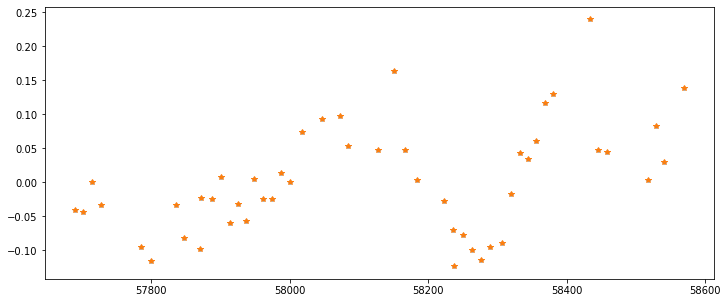

In [2]:
x=np.asarray(mjd_obs[mask], dtype=float)
y=np.asarray(delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]), dtype=float)
yerr = np.std(y)*np.ones(len(y)) #since i do not have the error i am using the std instead
n=len(x)
test2=[57690.156444, 57702.042152,57714.09288,57727.058406,57785.33735,57799.337204,57835.345248,57847.218598,57870.38101,57872.34736,57887.334724,57901.294798,57913.261906,57925.123674,57937.187432,57949.16307,57962.127284,57974.094412,57987.048386,58000.303966,58018.23316,58047.208566,58072.050364,58084.055702,58127.353694,58151.287814,58166.326436,58183.323268,58222.31519,58236.377956,58237.3749525,58250.340886,58263.305154,58276.365486,58289.241552,58307.182884,58320.122346,58332.115664,58344.081428,58356.048366,58368.331064,58380.28918,58433.114668,58445.050324,58458.058774,58517.347406,58529.33535,58541.3453,58569.380416]
X = np.array(test2)#np.linspace(min(x), max(x), n)[:, None]
X=np.reshape(X,(49,1))

print(X.shape)
#Just a plot to see if i have reshaped the data correctly 
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plt.plot(x,y,'.')
plt.plot(X,y,'*')

In [3]:
#We specify the prior distribution for the model parameters as normal distributions after the
#Kelly 2009 values. Kelly does write that the priors should be uniform, but the Stan people write that
#this is a bad idea and that something like a normal distributions should be used instead. 

#Sadly Skielboe et al. 2015 does not write up their priors for the model parameters.

#ℓ is related to ℓ_true by ℓ_true=2*ℓ^2, where ℓ_true is the typical timescale of variations.
#I use the result from Kelly 2009 where the range for ℓ_true is 10<ℓ_true<10^4 days with a true
#dispersion likely around 0.3 dex. I calculate the ℓ mean and sigma prior values from the ℓ_true values. 
#Maybe i should try a uniform prior here as well though the values found in Kelly 2009 are not uniform.

#η is what Skielboe et al. 2015 call σ and it is the long-term standard deviation. 
#Using a normal distribution with the mean as the standard deviation of the data and sigma as a guess.
#i get negative stdev values. i tried a uniform prior between 0 and 1 that seems to work. 
#A Halfnormal distribution also gives the same result.

#σ is the noise scale in the data such that if y is the observed values and f(x) is the underlying 
#unknown function, then y=f(x)+epsilon where the noise epsilon is Gaussian. 
#This value is the most confusing to me. 
#How do we determine the scale of the Gaussian white noise? Is it white noise at all for us?
#Kelly 2009 writes that there is a epsilon(t) white noise process with zero mean and variance equal
#to 1 and it is assumed that this process is also Gaussian. I apply a halfnormal distribution to the
#noise with the scale specified by the variance as sigma=sqrt(pi/(pi-2))*sqrt(Var) where Var=1 in our case.

#A uniform prior is given by something like pm.Uniform('parameter', lower=-10, upper=5)

with pm.Model() as model:
    ℓ = pm.Uniform('ℓ', lower=np.sqrt(5.0), upper=50.0*np.sqrt(2.0)) #pm.Normal("ℓ", mu=16.0, sigma=1.0) #the mean and sigma values here are rounded off. 
    η = pm.Uniform('η', lower=0.0, upper=1.0)#pm.Normal("η", mu=np.std(y), sigma=0.02) #pm.HalfCauchy("η", beta=0.5)

    cov = η**2 * pm.gp.cov.Exponential(1, ℓ)#i could add a alpha parameter here to take different PSD slopes into account.
    gp = pm.gp.Marginal(cov_func=cov)#we might want to implement a constant mean function here
    #with the long term mean as the mean of the data points (0.0015780001270527743) instead of zero.
    
    σ = pm.HalfNormal("σ", sigma=np.sqrt(np.pi/(np.pi-2)))#pm.HalfCauchy("σ", beta=0.5)
    y_ = gp.marginal_likelihood("y", X=X, y=y, noise=σ)

    #mp = pm.find_MAP() #The Maximum A Posteriori values
    trace = pm.sample(2000) #The NUTS sampling 

C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` 

In [ ]:
## The Maximum A Posteriori or MAP values is the mean/mode of the posterior parameter prob. distribution. 
#the ℓ_true we are looking for is ℓ_true=2*ℓ^2  
import pandas as pd
pd.DataFrame({"Parameter": ["ℓ","ℓ_true","η", "σ"],
              "Value at MAP": [float(mp["ℓ"]),float(2*mp["ℓ"]**2) ,float(mp["η"]), float(mp["σ"])],
             "Units": ["days^(1/2)","days","days", "mag"],})

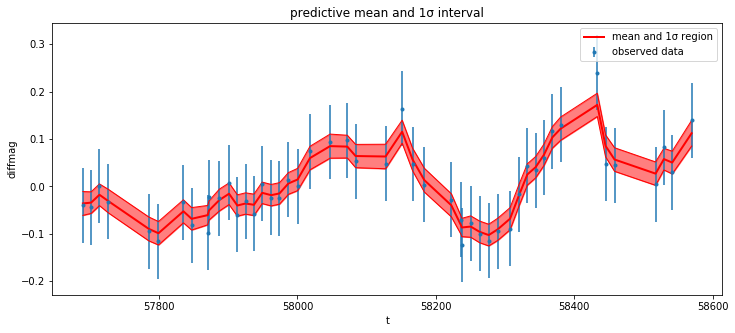

In [245]:
# predict
mu, var = gp.predict(X, point=mp, diag=True)
sd = np.sqrt(var)

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X, mu + 1*sd, 'r', lw=1); plt.plot(X, mu - 1*sd, 'r', lw=1);
plt.fill_between(X.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();

In [246]:
# add the GP conditional to the model, given the X values
with model:
    f_pred = gp.conditional("f_pred", X)

# To use the MAP values, you can just replace the trace with a length-1 list with `mp`
with model:
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=2000)

100%|██████████| 2000/2000 [00:51<00:00, 39.06it/s]


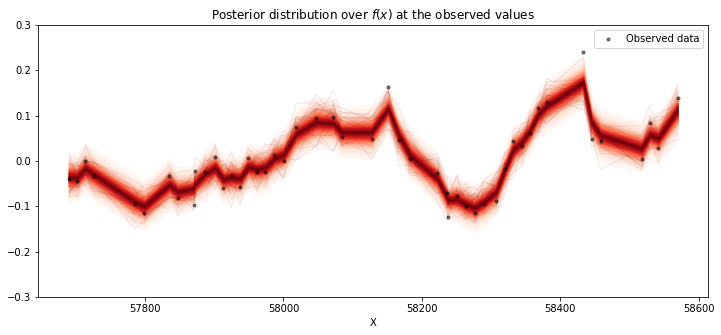

In [247]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X);

# plot the data and the true latent function
#plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylim([-0.3,0.3]);
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();

This part of the script shows the trace from the NUTS sampling.

C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ,49.128087,13.558470,0.205405,25.355373,70.675569,4963.765449,1.000448
η,0.082460,0.016531,0.000272,0.053087,0.115937,4113.896150,1.000290
σ,0.031586,0.007874,0.000129,0.016401,0.046870,3908.650956,1.000210


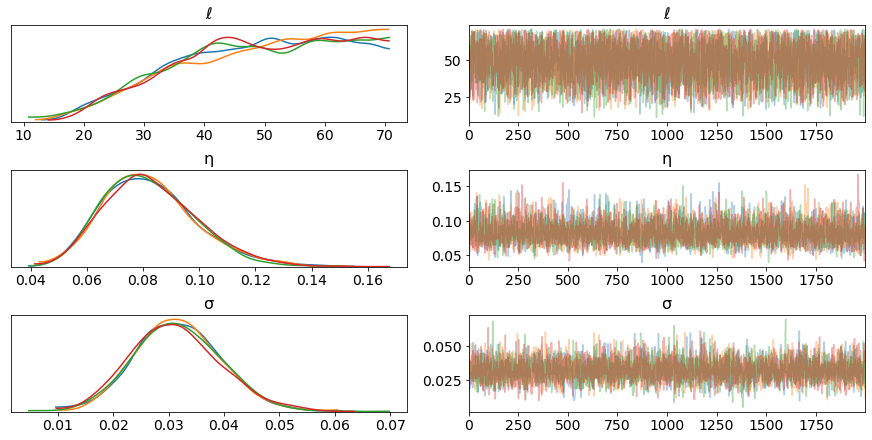

In [4]:
pm.traceplot(trace)
pm.summary(trace)

In [5]:
# add the GP conditional to the model, given the X values
with model:
    f_pred = gp.conditional("f_pred", X)
    
with model:
    pred_samples = pm.sample_posterior_predictive(trace, vars=[f_pred], samples=1000)

C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
  0%|          | 0/1000 [00:00<?, ?it/s]C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
C:\Users\Ejer\Anaconda3\lib\site-packages\theano\tensor\basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future

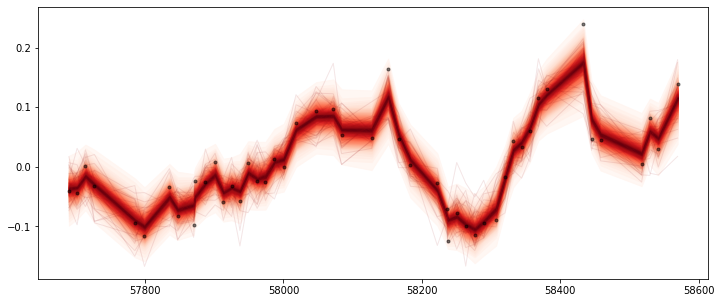

In [6]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, pred_samples["f_pred"], X);

# plot the data and the true latent function
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

Pay no mind to any of this stuff.

In [248]:
 import operator
# using map() + operator.sub 
# generate successive difference list 
res = list(map(operator.sub, X[1:], X[:-1]))
print(res)
print(np.mean(res))
print(max(X)-min(X))
print(yerr)
print(np.mean(y))

[array([11.885708]), array([12.050728]), array([12.965526]), array([58.278944]), array([13.999854]), array([36.008044]), array([11.87335]), array([23.162412]), array([1.96635]), array([14.987364]), array([13.960074]), array([11.967108]), array([11.861768]), array([12.063758]), array([11.975638]), array([12.964214]), array([11.967128]), array([12.953974]), array([13.25558]), array([17.929194]), array([28.975406]), array([24.841798]), array([12.005338]), array([43.297992]), array([23.93412]), array([15.038622]), array([16.996832]), array([38.991922]), array([14.062766]), array([0.9969965]), array([12.9659335]), array([12.964268]), array([13.060332]), array([12.876066]), array([17.941332]), array([12.939462]), array([11.993318]), array([11.965764]), array([11.966938]), array([12.282698]), array([11.958116]), array([52.825488]), array([11.935656]), array([13.00845]), array([59.288632]), array([11.987944]), array([12.00995]), array([28.035116])]
18.31716608333333
[879.223972]
[0.07904579 0.

0.9999999999999999


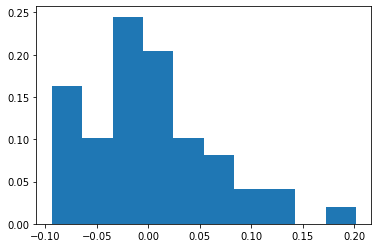

In [9]:
res=y-mu
weights = np.ones_like(res)/float(len(res))
print(np.sum(weights))
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

muhist = 0
variance = 1
sigmahist = math.sqrt(variance)
xhist = np.linspace(muhist - 3*sigmahist, muhist + 3*sigmahist, 100)

#plt.plot(xhist, stats.norm.pdf(xhist, muhist, sigmahist))
plt.hist(res, weights=weights,density=False)
plt.show()

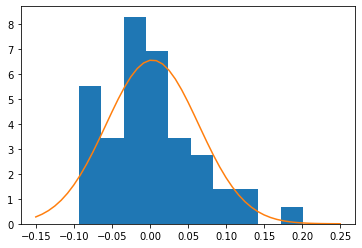

In [10]:
from scipy import stats  
import numpy as np  
import matplotlib.pylab as plt

# create some normal random noisy data
ser = res

# plot normed histogram
plt.hist(ser, density=True)

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = min(xt), max(xt)  
lnspc = np.linspace(xmin, xmax, len(ser))

# lets try the normal distribution first
m, s = stats.norm.fit(ser) # get mean and standard deviation  
pdf_g = stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Norm") # plot it

plt.show() 

In [11]:
print(m)
print(s**2)

0.0031882056168827
0.003701590614135826
